<a href="https://colab.research.google.com/github/abh2050/Codes/blob/master/LSTM_Autoencoder_for_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The first step is download the ECG data which is in the Google Drive

In [1]:
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /content/ECG5000.zip
100% 10.6M/10.6M [00:00<00:00, 84.3MB/s]


Next we need to unzip the file

In [2]:
!unzip --qq ECG5000.zip

Import all the dependencies

In [3]:
import seaborn as sns
import matplotlib as mpl
import numpy as np
import torch
from scipy.io.arff import loadarff 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [4]:
from scipy.io.arff import loadarff 
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import time
import copy
import shutil
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets,transforms,models

%matplotlib inline 
%config InlineBackend.figure_format ='retina'

sns.set(style='whitegrid',palette='muted',font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

mpl.rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


Getting the Pytorch Device in Place

In [5]:
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Load Data as Pandas

In [6]:
with open('ECG5000_TRAIN.arff') as f:
  raw_data = loadarff(f)
  train = pd.DataFrame(raw_data[0])

In [7]:
with open('ECG5000_TEST.arff') as f:
  raw_data1 = loadarff(f)
  test = pd.DataFrame(raw_data1[0])

Making sure the data loaded properly.

In [8]:
test.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,3.690844,0.711414,-2.114091,-4.141007,-4.574472,-3.431909,-1.950791,-1.107067,-0.632322,0.334577,...,0.022847,0.188937,0.480932,0.629250,0.577291,0.665527,1.035997,1.492287,-1.905073,b'1'
1,-1.348132,-3.996038,-4.226750,-4.251187,-3.477953,-2.228422,-1.808488,-1.534242,-0.779861,-0.397999,...,1.570938,1.591394,1.549193,1.193077,0.515134,0.126274,0.267532,1.071148,-1.164009,b'1'
2,1.024295,-0.590314,-1.916949,-2.806989,-3.527905,-3.638675,-2.779767,-2.019031,-1.980754,-1.440680,...,0.443502,0.827582,1.237007,1.235121,1.738103,1.800767,1.816301,1.473963,1.389767,b'1'
3,0.545657,-1.014383,-2.316698,-3.634040,-4.196857,-3.758093,-3.194444,-2.221764,-1.588554,-1.202146,...,0.777530,1.119240,0.902984,0.554098,0.497053,0.418116,0.703108,1.064602,-0.044853,b'1'
4,0.661133,-1.552471,-3.124641,-4.313351,-4.017042,-3.005993,-1.832411,-1.503886,-1.071705,-0.521316,...,1.280823,1.494315,1.618764,1.447449,1.238577,1.749692,1.986803,1.422756,-0.357784,b'1'


In [28]:
df =train.append(test)
df.head()


,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,b'1'
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,b'1'
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,b'1'
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,b'1'
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,b'1'


Checking the shape of the dataset

In [10]:
df.shape

(5000, 141)

We need to shuffle the dataset to insure there is no ordering.

In [11]:
df=df.sample(frac=1.0)

Data
The dataset contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. Source

We have 5 types of hearbeats (classes):

1. Normal (N)
2. Premature Ventricular Contraction (PVC)
3. R-on-T Premature Ventricular Contraction (R-on-T PVC)
4. Supra-ventricular Premature or Ectopic Beat (SP or EB)
5. Unclassified Beat (UB).

Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle. Frequency: 60–100 per minute (Humans) Duration: 0.6–1 second (Humans)

In [12]:
CLASS_NORMAL = 1
class_names =['Normal','PVC', 'R on T','SP','UB']

#Data Preprocessing Steps

In [13]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [14]:
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,b'1'
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,b'1'
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,b'1'
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,b'1'
205,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,b'1'


Exploration

In [15]:
df.target.value_counts()

b'1'    2919
b'2'    1767
b'4'     194
b'3'      96
b'5'      24
Name: target, dtype: int64

Next we can look at the visualization of all the class of defects

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


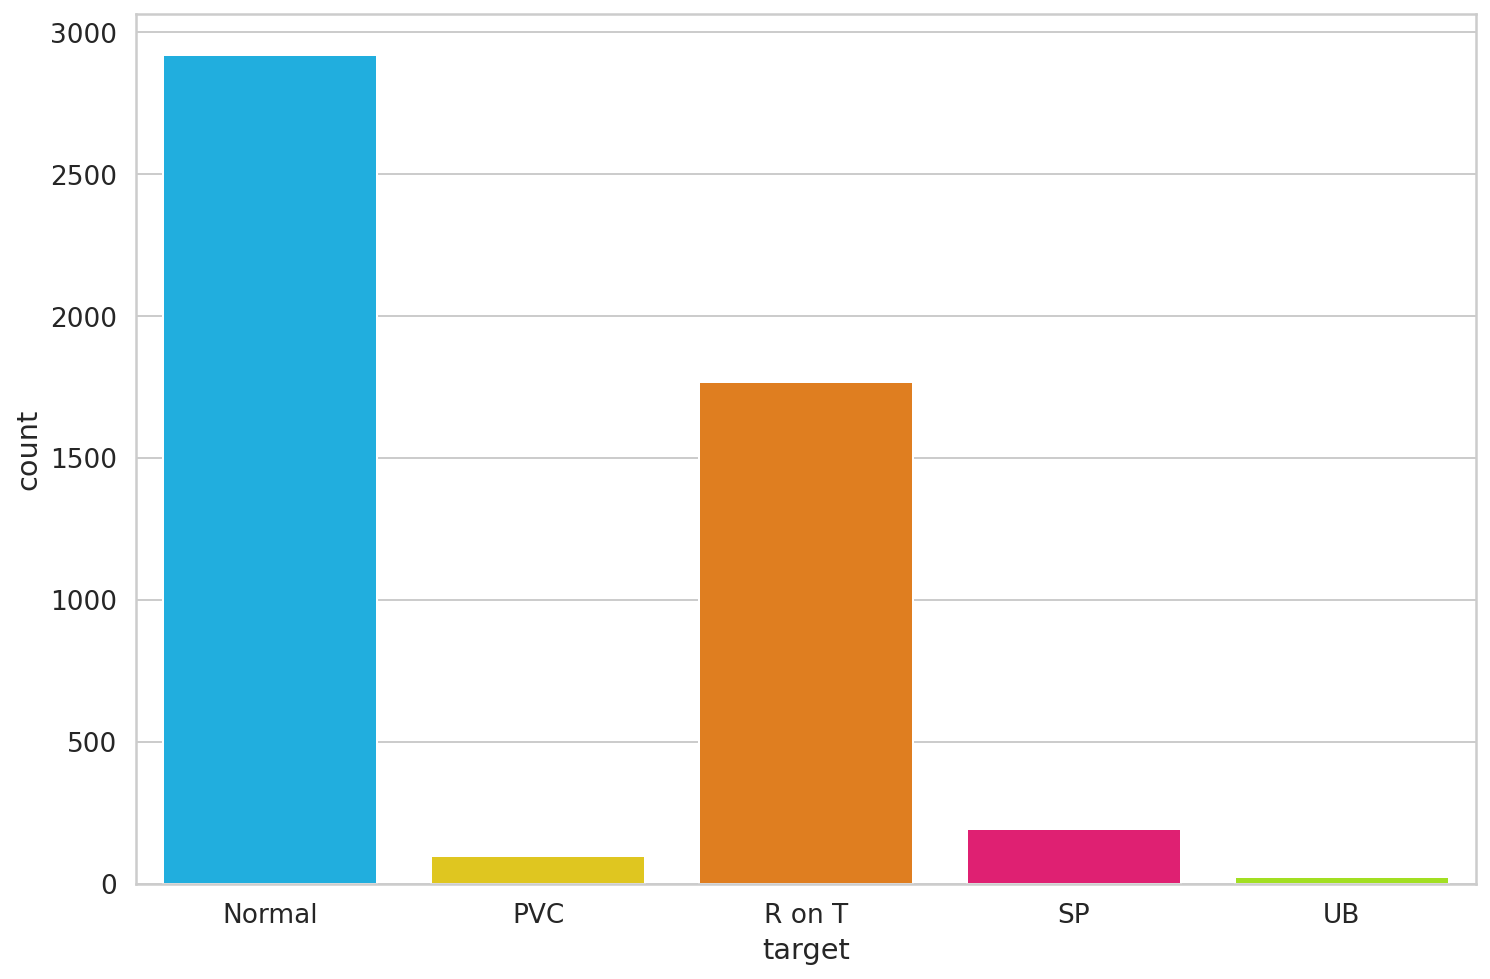

In [16]:
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);

The normal class, has by far, the most examples. This is great because we'll use it to train our model.

Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:

In [17]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

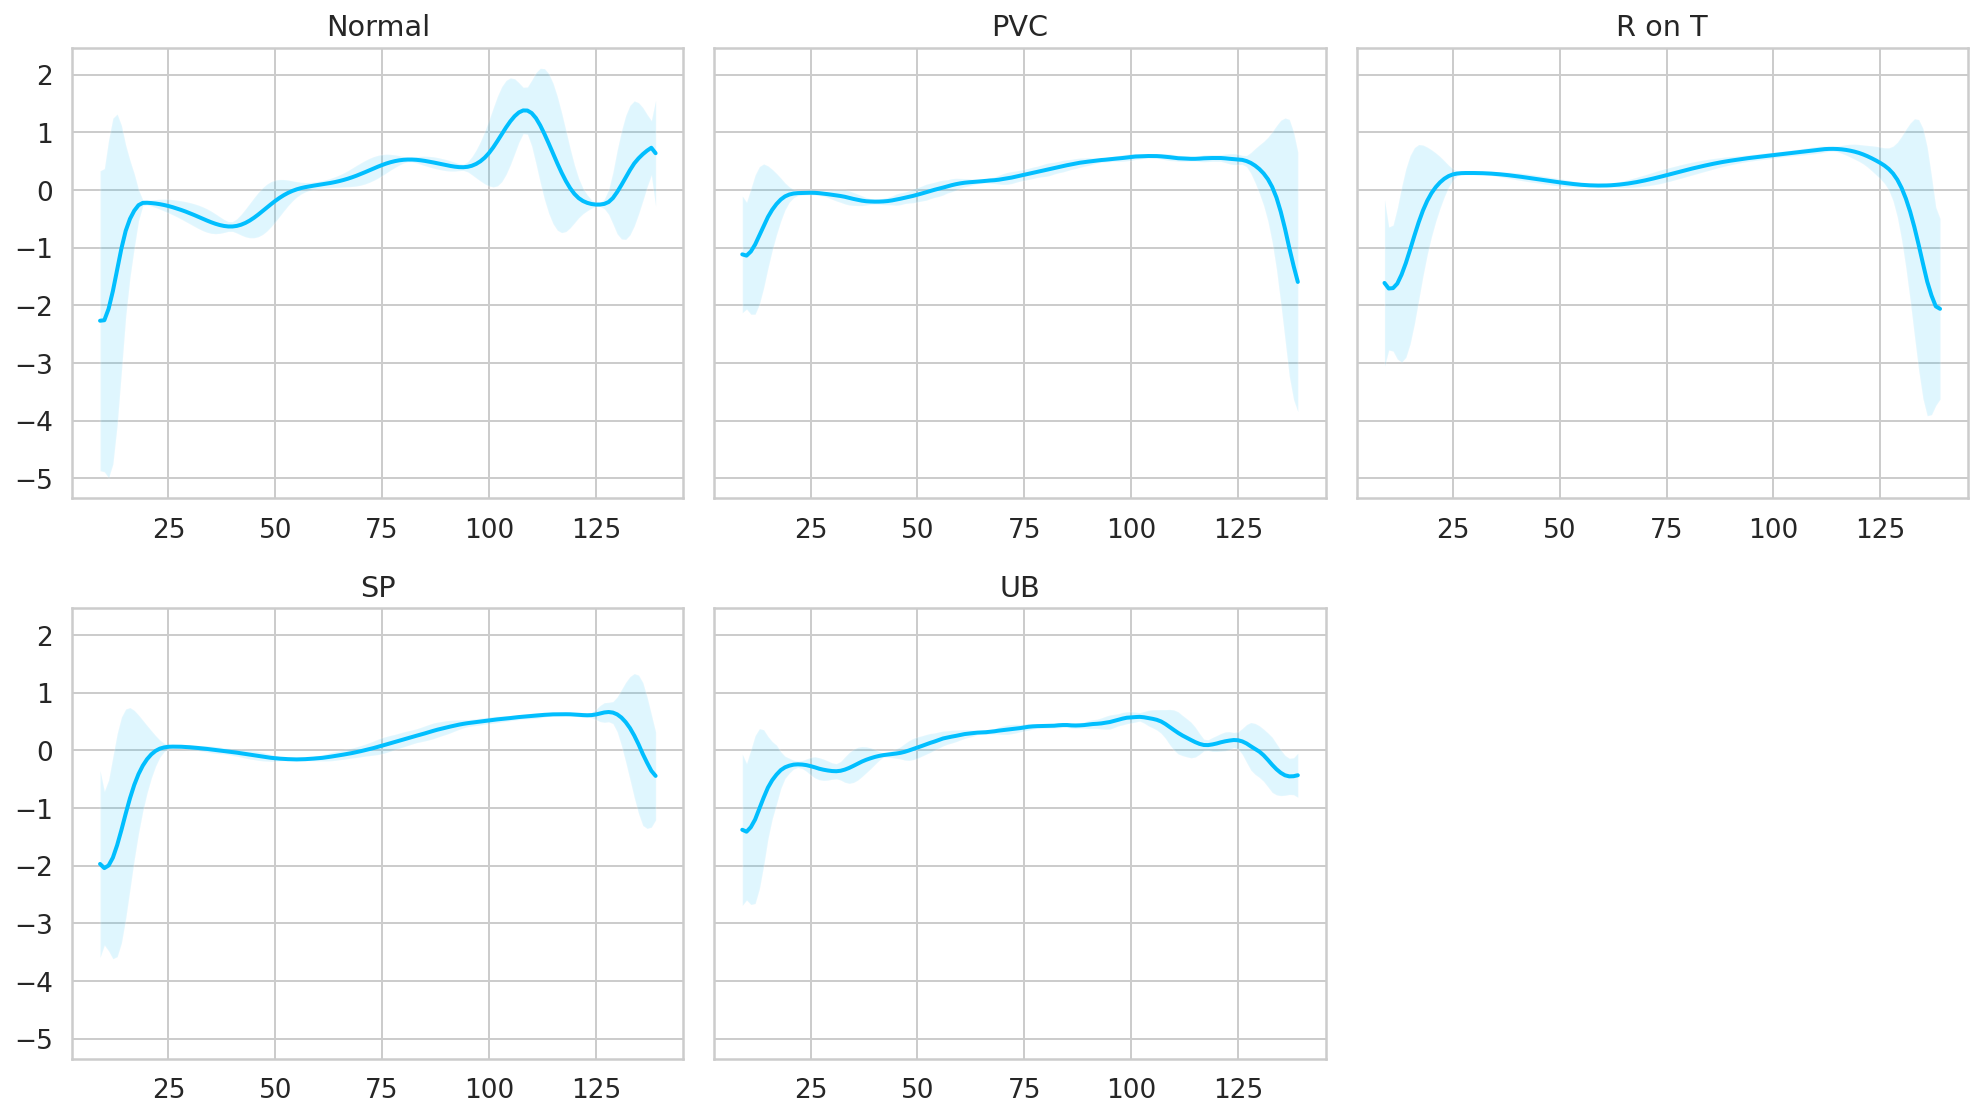

In [18]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

As we can see from the data, the normal class has a distinctly different patterns than other patterns

An LSTM Autoencoder is an implementation of an autoencoder for sequence data using an Encoder-Decoder LSTM architecture.

For a given dataset of sequences, an encoder-decoder LSTM is configured to read the input sequence, encode it, decode it, and recreate it. The performance of the model is evaluated based on the model’s ability to recreate the input sequence.

Once the model achieves a desired level of performance recreating the sequence, the decoder part of the model may be removed, leaving just the encoder model. This model can then be used to encode input sequences to a fixed-length vector.

The resulting vectors can then be used in a variety of applications, not least as a compressed representation of the sequence as an input to another supervised learning model.

The Autoencoder’s job is to get some input data, pass it through the model, and obtain a reconstruction of the input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data.

In a sense, Autoencoders try to learn only the most important features (compressed version) of the data. Here, we’ll have a look at how to feed Time Series data to an Autoencoder. We’ll use a couple of LSTM layers (hence the LSTM Autoencoder) to capture the temporal dependencies of the data.

To classify a sequence as normal or an anomaly, we’ll pick a threshold above which a heartbeat is considered abnormal.

Reconstruction Loss
When training an Autoencoder, the objective is to reconstruct the input as best as possible. This is done by minimizing a loss function (just like in supervised learning). This function is known as reconstruction loss. Cross-entropy loss and Mean squared error are common examples.

Anomaly Detection in ECG Data
We'll use normal heartbeats as training data for our model and record the reconstruction loss. But first, we need to prepare the data:

Data Preprocessing
Let's get all normal heartbeats and drop the target (class) column:

Let's get all normal heartbeats and drop the target (class) column:

In [19]:
normal_df = df[df.target==b'1'].drop(labels='target',axis =1)

In [20]:
normal_df.shape

(2919, 140)

We'll merge all other classes and mark them as anomalies:

In [21]:
anomaly_df = df[df.target !=b'1'].drop(labels='target',axis =1)

In [22]:
anomaly_df.shape

(2081, 140)

We'll split the normal examples into train, validation and test sets:

In [23]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

We need to convert our examples into tensors, so we can use them to train our Autoencoder. Let's write a helper function for that:

In [24]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape sequence length x number of features (140x1 in our case).

Let's create some datasets:

In [25]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

#Building an LSTM Autoencoder
The theory behind the autoencoders is to trying to reduce the dimentionality of the dataset and increase the dimentionality through autoencoding. During the reconstruction phase, the model tries to reconstruct the heart beat data normally. As we provide the anomaly data to the model, the reconstruction error is high as error is propagated showing the anomalies which is what we are looking for.

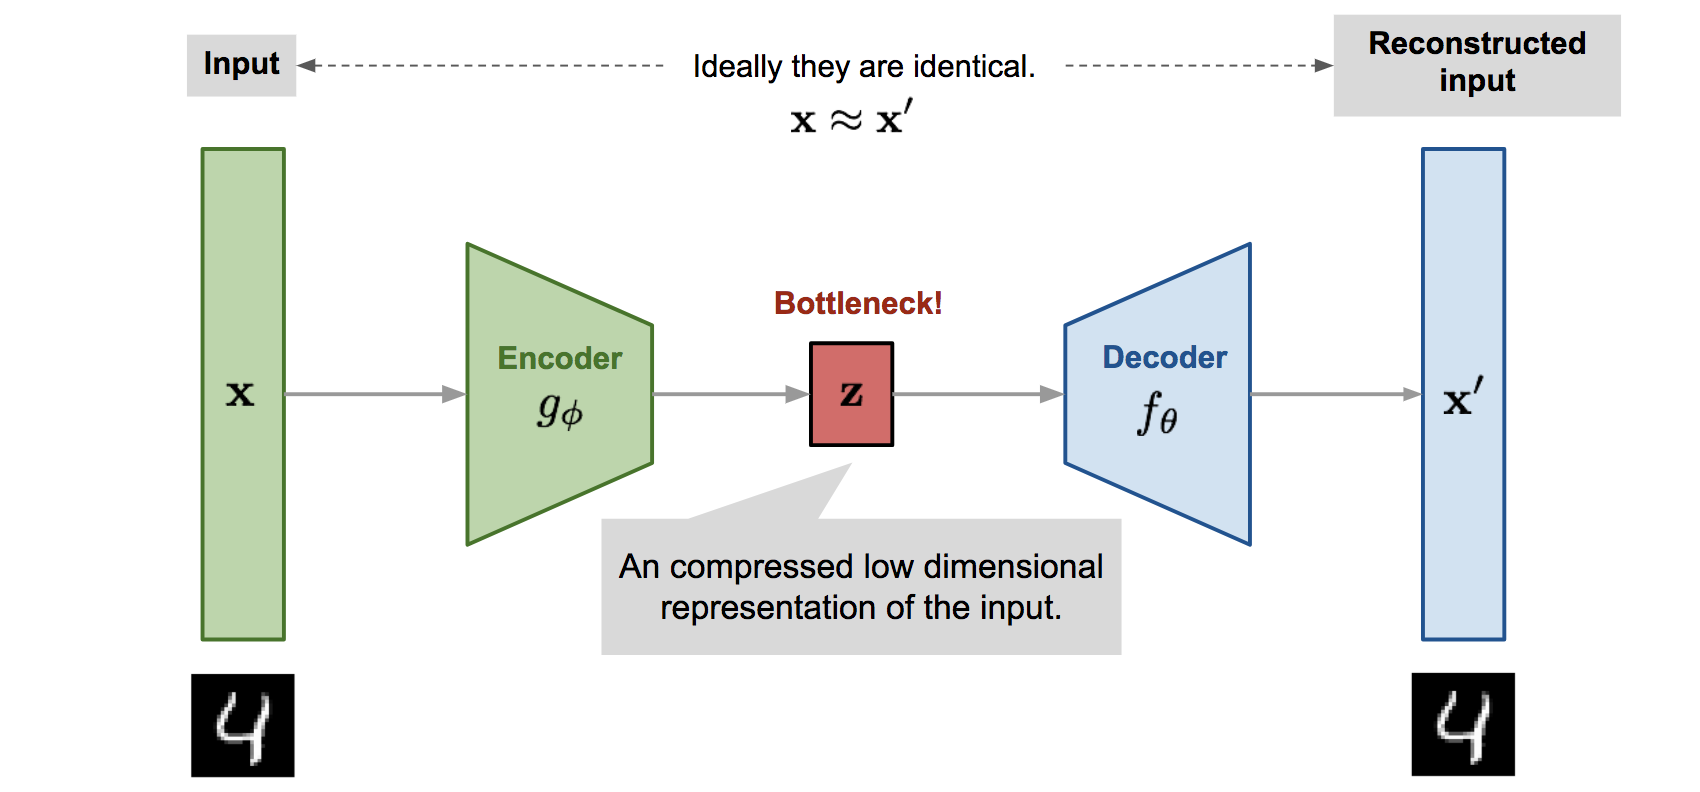

The general Autoencoder architecture consists of two components. An Encoder that compresses the input and a Decoder that tries to reconstruct it.

In [29]:
#Encoder is 2 separate layers of the LSTM RNN 
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
  # Initializing the hidden numbers of layers
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

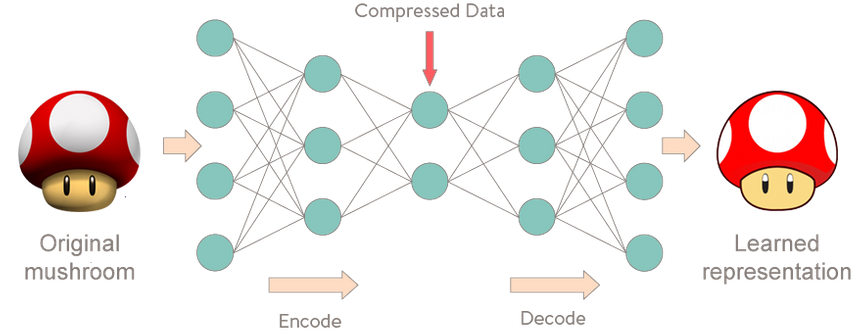

We optimize the parameters of our Autoencoder model in such way that a special kind of error - reconstruction error is minimized. In practice, the traditional squared error is often used:

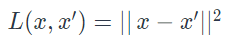

The Encoder uses two LSTM layers to compress the Time Series data input.

Next, we'll decode the compressed representation using a Decoder. And increase the dimenstionality of the layer.

In [30]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )
#Using a dense layer as an output layer
    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

In [31]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:

In [32]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

Training
Building a training model

In [33]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

#Next We need to evaluate the dataset 

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

Next we need to train the model by calling the function

In [ ]:
#model,history = train_model(model,train_dataset,val_dataset,n_epochs=200)

Epoch 1: train loss 75.75512882434087 val loss 56.405046339327974

Epoch 2: train loss 54.076116488086555 val loss 50.939927866027624

Epoch 3: train loss 50.92283613227251 val loss 49.824175356191176

Epoch 4: train loss 49.0239486517516 val loss 48.190363307861745

Epoch 5: train loss 48.14581578049819 val loss 46.90872137050173

Epoch 6: train loss 47.223967487222964 val loss 46.35907604100354

Epoch 7: train loss 47.900260198793795 val loss 54.42922741886699

Epoch 8: train loss 46.736308542579856 val loss 44.99067691894115

Epoch 9: train loss 37.391528863764634 val loss 30.752771631442645

Epoch 10: train loss 27.776124878114196 val loss 28.94559245386221

Epoch 11: train loss 28.943304791079562 val loss 44.7654419661382

Epoch 12: train loss 46.98424231664926 val loss 49.138860175227144

Epoch 13: train loss 42.22767452961108 val loss 50.482073227293256

Epoch 14: train loss 47.689477888243374 val loss 44.84123421366304

Epoch 15: train loss 43.52396634296754 val loss 37.75412936422198

Epoch 16: train loss 34.30551355877791 val loss 31.293927606055355

Epoch 17: train loss 28.782830124946912 val loss 22.659882903505917

Epoch 18: train loss 25.942896074558735 val loss 34.80483398177111

Epoch 19: train loss 26.53549621663522 val loss 35.70071094109337

Epoch 20: train loss 26.878577799722102 val loss 26.47056831841583

Epoch 21: train loss 23.629037454213794 val loss 29.925236448086164

Epoch 22: train loss 23.911274584778276 val loss 21.65711168543064

Epoch 23: train loss 23.16069320784803 val loss 21.856958897040567

Epoch 24: train loss 21.99251588454702 val loss 19.900527563518224

Epoch 25: train loss 21.77668279373372 val loss 20.57084183806852

Epoch 26: train loss 22.081027976546928 val loss 31.943435170951556

Epoch 27: train loss 21.56032870268447 val loss 19.901263839148825

Epoch 28: train loss 20.089733965788 val loss 18.139123597649583

Epoch 29: train loss 19.96293655723778 val loss 17.775442605132536

Epoch 30: train loss 20.210994332608365 val loss 18.733563052102568

Epoch 31: train loss 19.409291037913533 val loss 24.266767680848417

Epoch 32: train loss 19.38391114319106 val loss 17.422684181265456

Epoch 33: train loss 18.805052949458734 val loss 19.305405561427616

Epoch 34: train loss 18.41354357182427 val loss 19.091201049882805

Epoch 35: train loss 17.919071072390462 val loss 21.477752864564238

Epoch 36: train loss 18.119861689463395 val loss 16.632605845610843

Epoch 37: train loss 18.06746557690068 val loss 17.926609042561502

Epoch 38: train loss 18.89574191398267 val loss 20.02396113555179

Epoch 39: train loss 20.134830477928645 val loss 19.07063745557245

Epoch 40: train loss 18.298021643260753 val loss 15.485459822436649

Epoch 41: train loss 17.279723536627085 val loss 14.72217842661887

Epoch 42: train loss 17.207023689795868 val loss 15.81790247549376

Epoch 43: train loss 16.673997644357556 val loss 15.14312743977882

Epoch 44: train loss 16.317345853872425 val loss 13.706162988122413

Epoch 45: train loss 16.53377732919234 val loss 16.773259195451445

Epoch 46: train loss 17.74284644167253 val loss 21.48388053776868

Epoch 47: train loss 16.738192789692015 val loss 18.432621832186857

Epoch 48: train loss 16.921947479824635 val loss 15.682763718094028

Epoch 49: train loss 16.55991218321653 val loss 16.250387221066212

Epoch 50: train loss 17.485111765494416 val loss 20.516666744349354

Epoch 51: train loss 16.73545687970304 val loss 15.787216899338029

Epoch 52: train loss 15.622685805870034 val loss 19.050982035874508

Epoch 53: train loss 15.472290784973428 val loss 14.480499186206597

Epoch 54: train loss 15.521352857123071 val loss 14.835865980935992

Epoch 55: train loss 15.123836848486915 val loss 13.233599490273122

Epoch 56: train loss 14.937682524077212 val loss 16.92053673454519

Epoch 57: train loss 15.005951665765284 val loss 16.58751693764644

Epoch 58: train loss 15.174215905659624 val loss 14.647775288734827

Epoch 59: train loss 14.635044308354518 val loss 13.555696622503495

Epoch 60: train loss 14.503765875559957 val loss 13.2086515866042

Epoch 61: train loss 14.463172687152277 val loss 19.33603352165873

Epoch 62: train loss 14.334671135825142 val loss 15.373641311918917

Epoch 63: train loss 14.32489227566302 val loss 12.905770122801485

Epoch 64: train loss 14.08117091276145 val loss 12.079199320627154

Epoch 65: train loss 13.803238158358628 val loss 15.13823238249118

Epoch 66: train loss 13.919602440807523 val loss 15.678845978434175

Epoch 67: train loss 13.965259298688219 val loss 12.814368970565015

Epoch 68: train loss 13.809021224229868 val loss 14.07890467920401

Epoch 69: train loss 13.694650269092834 val loss 17.130755798808543

Epoch 70: train loss 13.595549478111897 val loss 13.901040327833782

Epoch 71: train loss 13.448489058454976 val loss 12.710753188605194

Epoch 72: train loss 13.453816091183066 val loss 12.025957446049505

Epoch 73: train loss 13.626774842678564 val loss 14.313379699459661

Epoch 74: train loss 13.046931093039891 val loss 12.893230076942835

Epoch 75: train loss 13.104360995971113 val loss 13.37616009435556

Epoch 76: train loss 13.256702469222635 val loss 12.372178268107131

Epoch 77: train loss 12.97038893178796 val loss 18.04526256457124

Epoch 78: train loss 12.809690363990448 val loss 11.196167099597918

Epoch 79: train loss 12.793351448624906 val loss 13.437239726655719

Epoch 80: train loss 12.789585790053724 val loss 15.033850409471947

Epoch 81: train loss 12.606104411410017 val loss 11.674935047943844

Epoch 82: train loss 12.531917935463268 val loss 11.437891633030498

Epoch 83: train loss 12.318862916768822 val loss 12.664271699690575

Epoch 84: train loss 12.753657868388006 val loss 11.782569117106675

Epoch 85: train loss 12.575772298338528 val loss 15.257970481195548

Epoch 86: train loss 12.222606849977923 val loss 12.302281321112206

Epoch 87: train loss 12.484432779555839 val loss 11.142147838865938

Epoch 88: train loss 12.516114923753166 val loss 13.095346232729968

Epoch 89: train loss 12.234586787963769 val loss 10.644748751213934

Epoch 90: train loss 12.167037908707064 val loss 11.368963694002849

Epoch 91: train loss 12.10385682207113 val loss 13.71555113873791

Epoch 92: train loss 11.902853176412156 val loss 11.47288822720889

Epoch 93: train loss 11.98078651670389 val loss 11.181045654283855

Epoch 94: train loss 12.512263981482041 val loss 12.7748051633607

Epoch 95: train loss 12.022403153908055 val loss 12.569304928437841

Epoch 96: train loss 12.01559951275599 val loss 10.62174914884079

Epoch 97: train loss 11.526333694158183 val loss 10.73882455630514

Epoch 98: train loss 12.167580054873952 val loss 12.98494577733323

Epoch 99: train loss 11.214418759128828 val loss 12.646652045917186

Epoch 100: train loss 11.588014840214832 val loss 11.064257738940139

Epoch 101: train loss 11.336279591933607 val loss 11.858755554355453

Epoch 102: train loss 11.4093856311815 val loss 10.585698508565336

Epoch 103: train loss 11.18782005248556 val loss 10.79099716993729

Epoch 104: train loss 11.178372653344619 val loss 10.543987944671319

Epoch 105: train loss 11.07755208351784 val loss 10.053662249659515

Epoch 106: train loss 10.998819611236868 val loss 10.708981160824615

Epoch 107: train loss 11.016502958879698 val loss 10.191263530848376

Epoch 108: train loss 10.932790973598753 val loss 10.627724743540377

Epoch 109: train loss 11.049162883520223 val loss 11.158510406676413

Epoch 110: train loss 11.045427016220184 val loss 10.74294033148183

Epoch 111: train loss 10.698421183635707 val loss 11.268010339639293

Epoch 112: train loss 10.971798640016297 val loss 11.161408889822585

Epoch 113: train loss 11.259980676252002 val loss 11.3282809452799

Epoch 114: train loss 10.558360003310314 val loss 11.623055090269538

Epoch 115: train loss 10.626629697368395 val loss 23.55220785238637

Epoch 116: train loss 10.671426939897026 val loss 10.12464359758657

Epoch 117: train loss 10.477379391050205 val loss 15.79209877769288

Epoch 118: train loss 10.681426686944619 val loss 11.137957812169306

Epoch 119: train loss 10.223775204416727 val loss 13.186299301251616

Epoch 120: train loss 10.36788113681312 val loss 14.163037003917498

Epoch 121: train loss 10.347269262723604 val loss 12.395882342862595

Epoch 122: train loss 10.64385450102542 val loss 10.014593886027157

Epoch 123: train loss 10.451111983215073 val loss 10.200677258162775

Epoch 124: train loss 10.209890181092858 val loss 10.148544129251214

Epoch 125: train loss 10.198652256500909 val loss 10.539463998514638

Epoch 126: train loss 10.415003857464619 val loss 10.915143984576542

Epoch 127: train loss 10.299078854472826 val loss 10.661337808537402

Epoch 128: train loss 10.049785330621335 val loss 10.968665199475076

Epoch 129: train loss 10.411835026423905 val loss 10.22858320893688

Epoch 130: train loss 10.298648491543851 val loss 11.436524083589937

Epoch 131: train loss 10.18139874209612 val loss 9.72154446266617

Epoch 132: train loss 9.873409641985448 val loss 12.279062136041427

Epoch 133: train loss 10.260823733957483 val loss 13.198536923314117

Epoch 134: train loss 10.1869789113541 val loss 13.138497940102535

Epoch 135: train loss 10.052632169058514 val loss 10.030022705781175

Epoch 136: train loss 9.86670422217674 val loss 10.531062933365233

Epoch 137: train loss 9.667260818835086 val loss 9.932617791276742

Epoch 138: train loss 9.734251651202705 val loss 10.332713395662275

Epoch 139: train loss 9.784715254621032 val loss 11.915596249160506

Epoch 140: train loss 9.65319977610018 val loss 9.728815225204103

Epoch 141: train loss 9.636839429393309 val loss 9.942375589963111

Epoch 142: train loss 9.742344003106163 val loss 10.068128536992512

Epoch 143: train loss 9.476021666144325 val loss 10.34718115419251

Epoch 144: train loss 9.93846365714544 val loss 12.620515906363217

Epoch 145: train loss 9.528006041064373 val loss 9.725362927433574

Epoch 146: train loss 9.5574056470841 val loss 10.714185247649105

Epoch 147: train loss 9.47234908768555 val loss 10.699638275563107

Epoch 148: train loss 9.361145816181802 val loss 9.905942965693034

Epoch 149: train loss 9.523792286257454 val loss 10.387393585244137

Epoch 150: train loss 9.620422649460423 val loss 10.133064628054257

Because it takes close to 16 hours to run the model we built this model before-hand and loaded it to the system

In [44]:
!gdown 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
model = torch.load('model.pth',map_location=torch.device('cpu'))
model = model.to(device)


Downloading...
From: https://drive.google.com/uc?id=1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
To: /content/model.pth
100% 3.98M/3.98M [00:00<00:00, 152MB/s]


/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Choosing a threshold
With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:

In [45]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


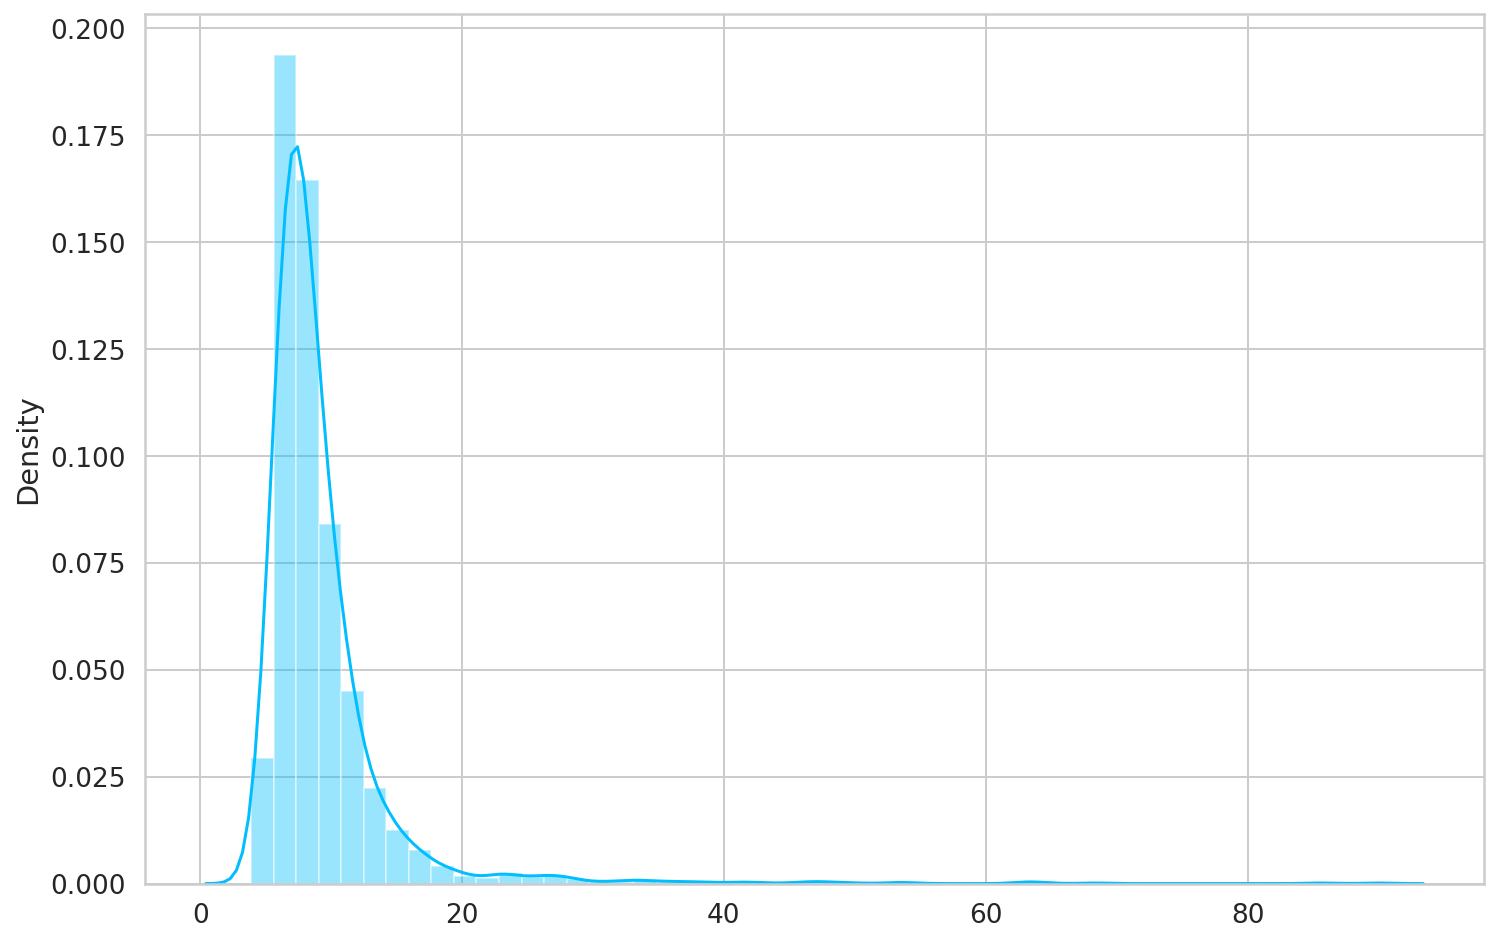

In [46]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [47]:
THRESHOLD = 26

Evaluation
Using the threshold, we can turn the problem into a simple binary classification task:

If the reconstruction loss for an example is below the threshold, we'll classify it as a normal heartbeat
Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly
Normal hearbeats
Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model haven't seen those):

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


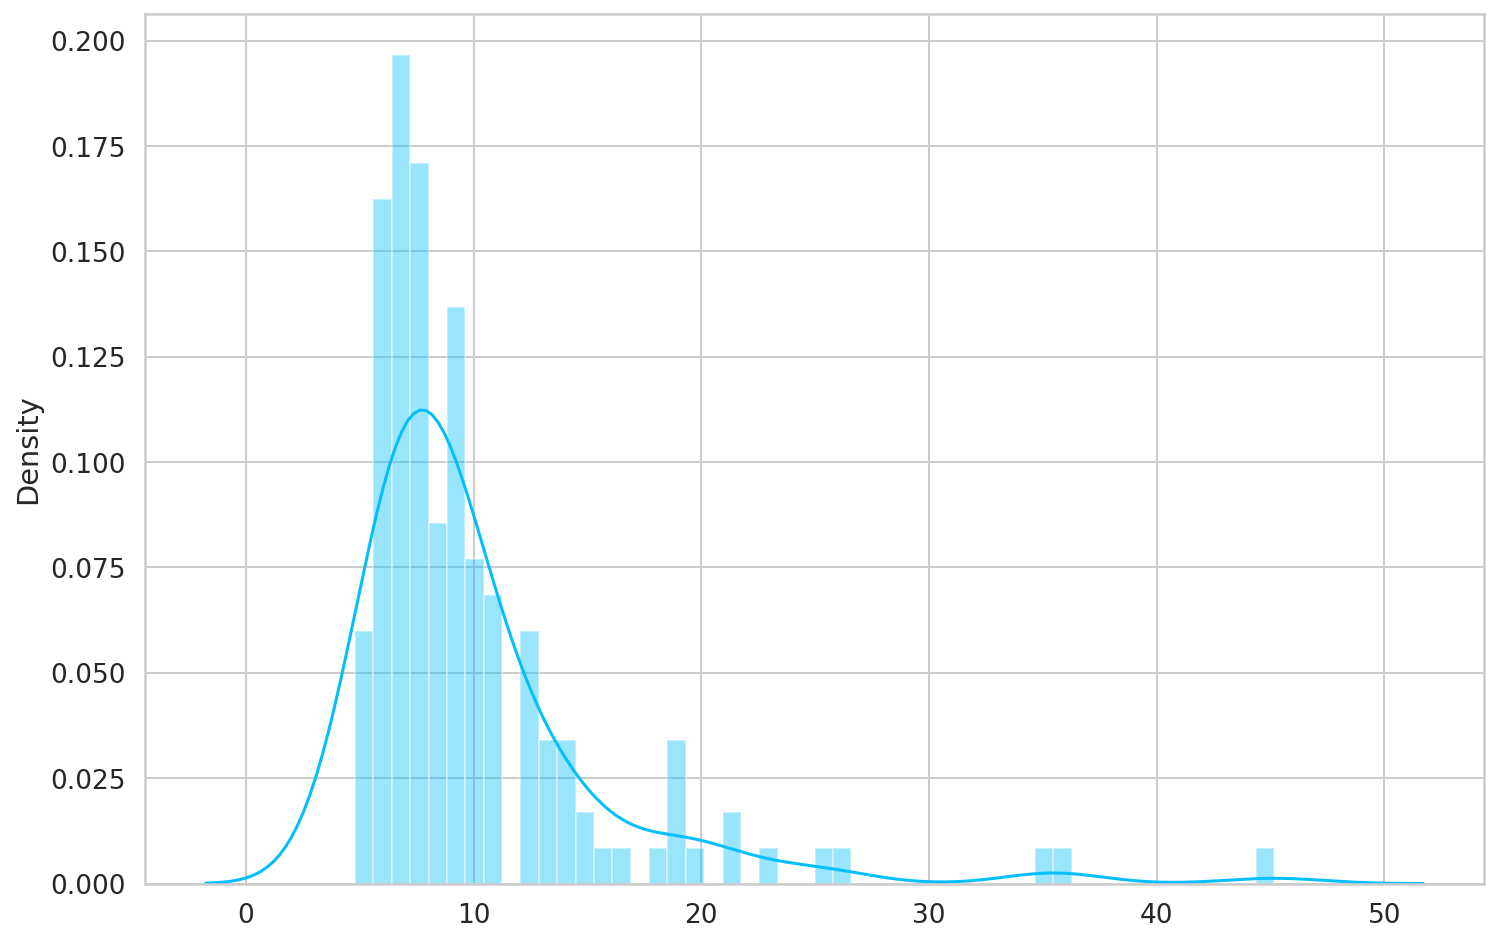

In [48]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

#We'll count the correct predictions:

In [49]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 142/145


Anomalies
We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal heartbeats:

In [50]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

Now we can take the predictions of our model for the subset of anomalies:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


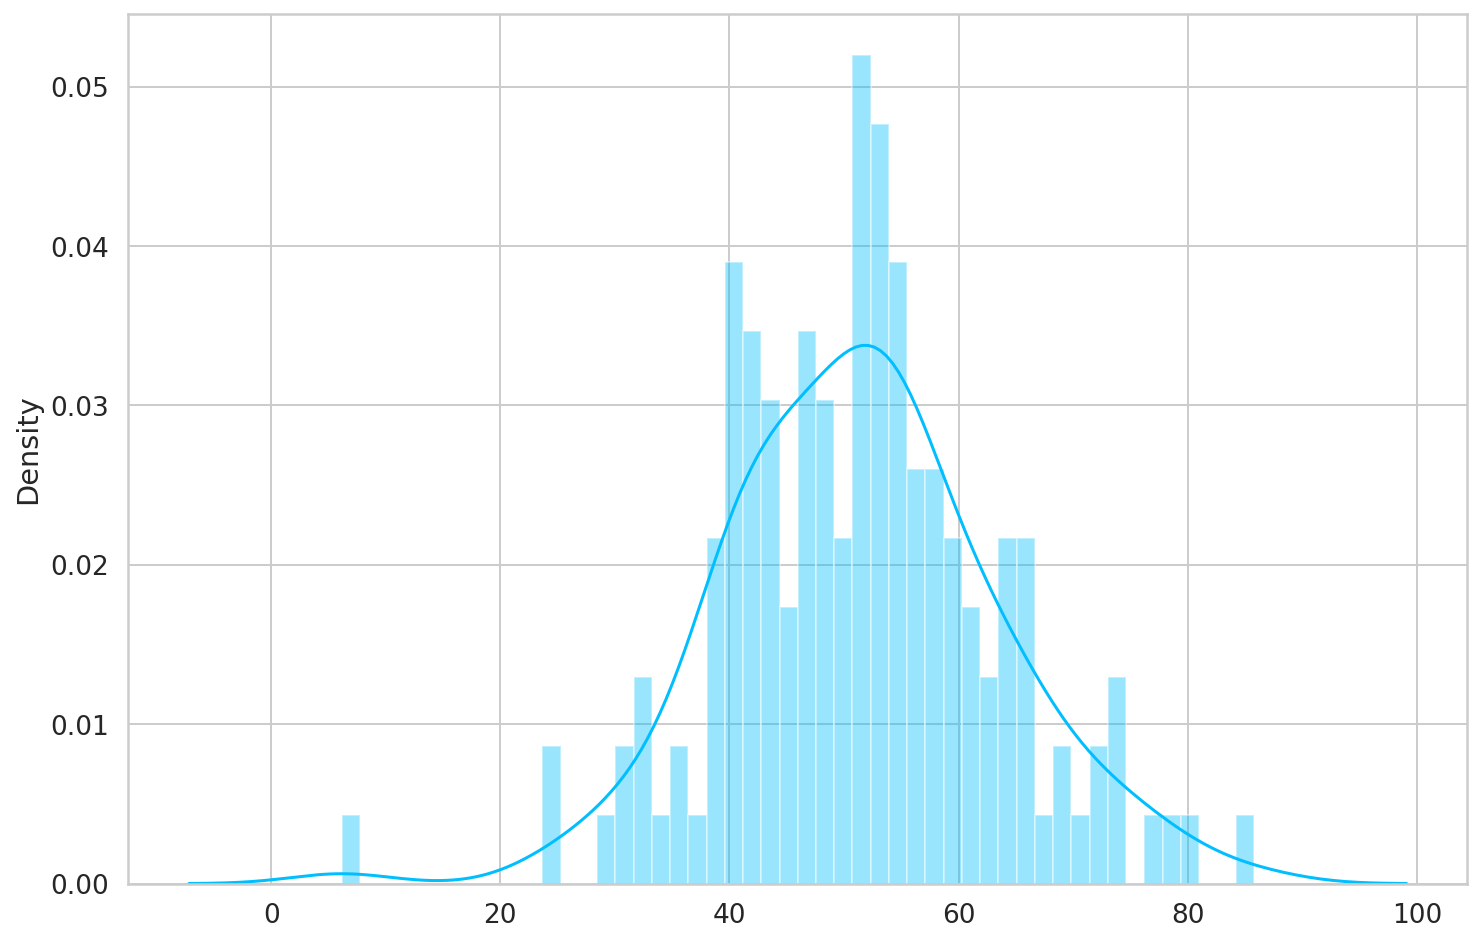

In [51]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

Finally, we can count the number of examples above the threshold (considered as anomalies):

In [52]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 142/145


We have very good results. In the real world, you can tweak the threshold depending on what kind of errors you want to tolerate. In this case, you might want to have more false positives (normal heartbeats considered as anomalies) than false negatives (anomalies considered as normal).

Looking at Examples
We can overlay the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:

In [53]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

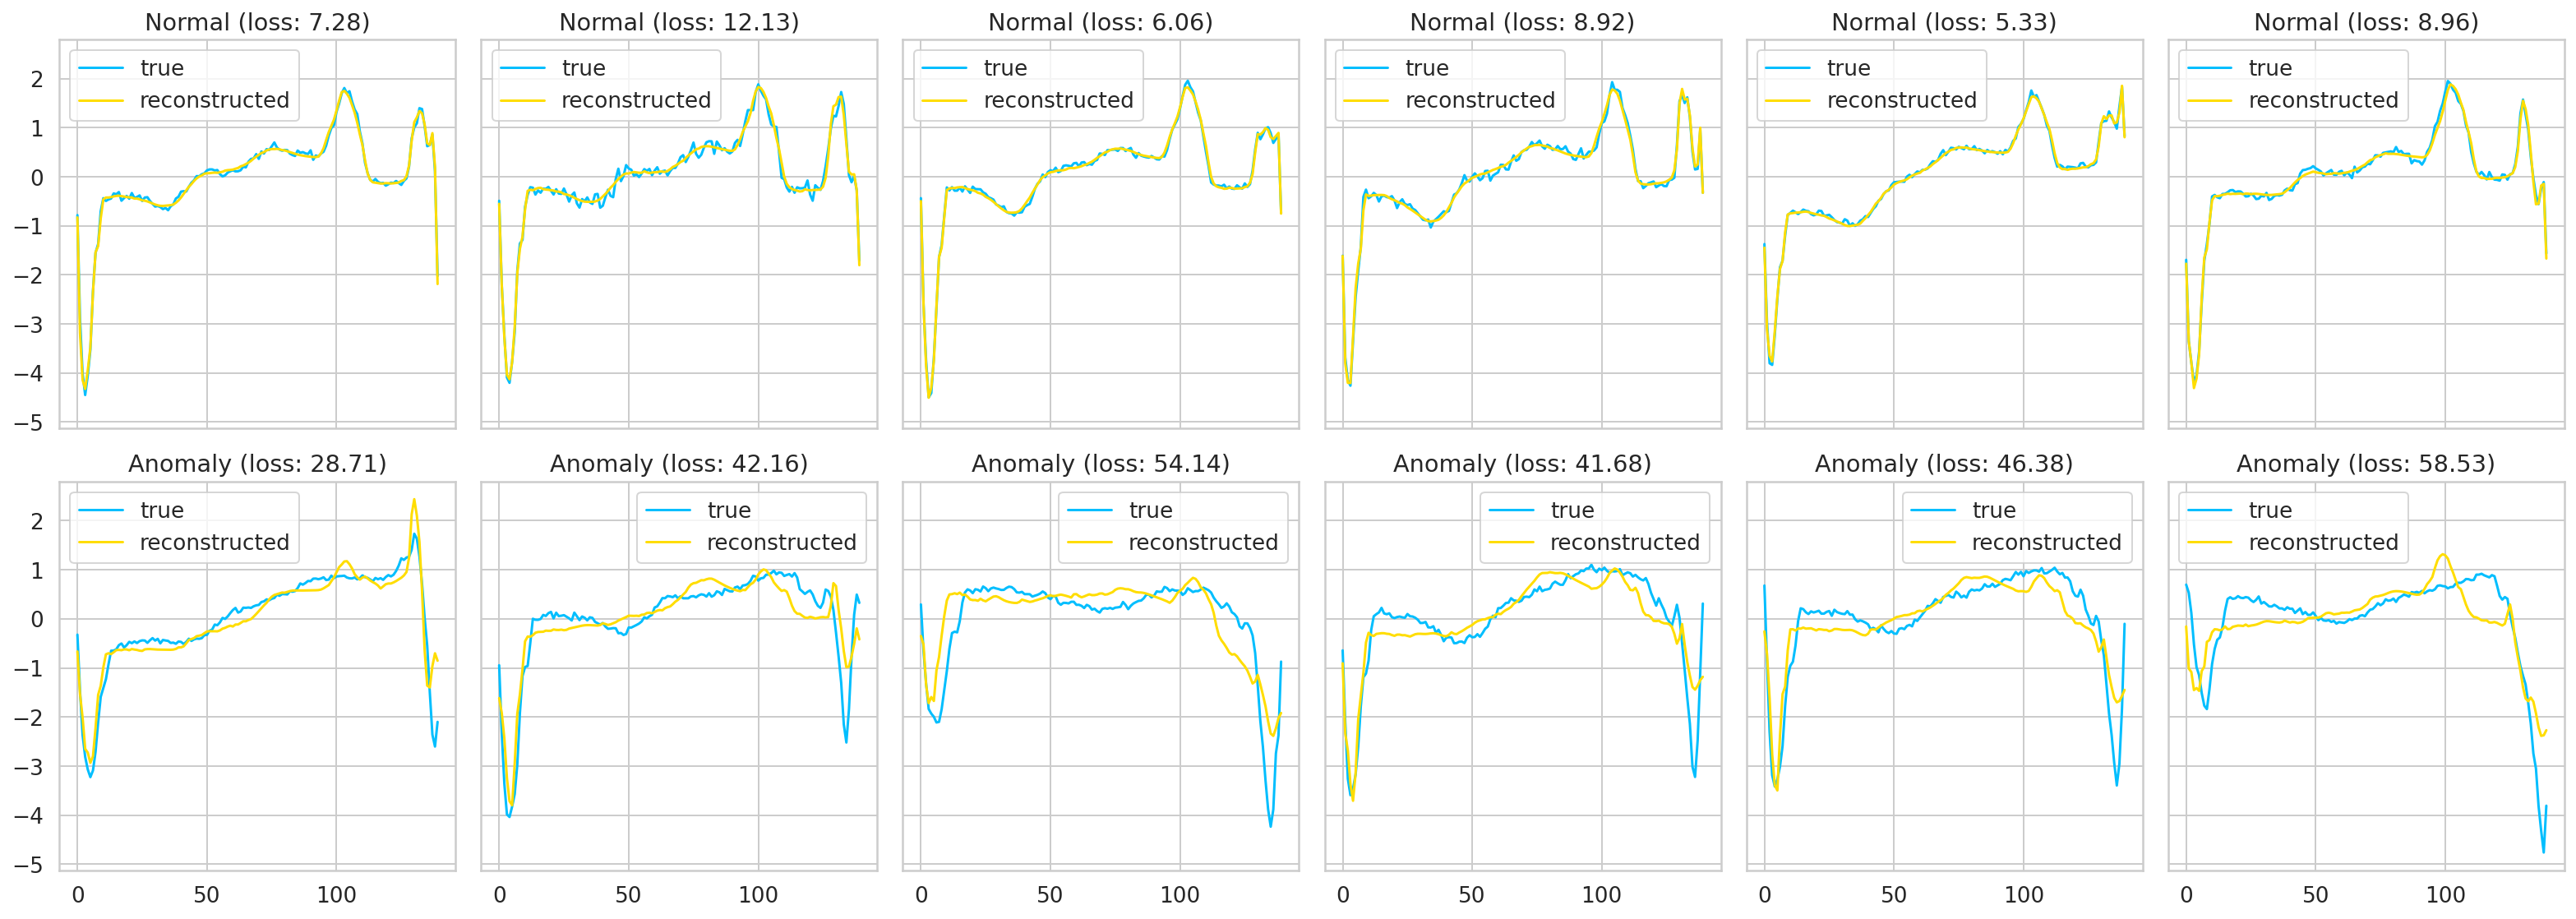

In [54]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

Thus, we can see that the normal is very well predicted but the anomalies dataset do not fit very well with the reconstructed data which shows us the anomaly in the heart beat. Thus our model is performing very well.

